In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tracked_object import TrackedObject

## So now we know we can track noisy non-linear movement in some arbitrary environment.

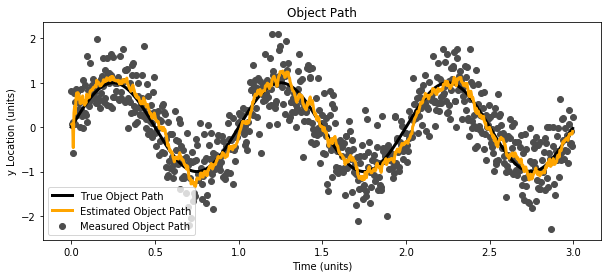

In [2]:
sigma = 0.5
t = np.arange(0, 3, 0.004)
x_true = [np.sin(2*np.pi*i) for i in t]
x_noisy = [i + np.random.normal(0, sigma, 1)[0] for i in x_true]
est_sigma = sigma + np.random.normal(0, sigma*0.01, 1)[0]
P = np.matrix((est_sigma**2)*np.identity(2))
Q = 0.00001*P
R = np.matrix((est_sigma**4) * np.identity(2))
x = np.matrix([x_noisy[1], x_noisy[1]-x_noisy[0]]).getT()
H = np.matrix(np.identity(2))
F = np.matrix([[1,1], [0, 1]])
to = TrackedObject()
to.configure_kalman_filter(x = x, P = P, Q = Q, R = R, H = H, F = F)

est_x_pos = [x[0,0]]
for i in range(2, len(x_noisy)):
    z_k = np.matrix([x_noisy[i], x_noisy[i] - x_noisy[i-1]]).getT()
    u_k = np.matrix([0])
    new_state = to.kf.update(u_k, z_k)
    est_x_pos.append(new_state[0,0])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(t, x_true, label="True Object Path", color='black', linewidth='3')
ax.scatter(t, x_noisy, label='Measured Object Path', color='0.3')
ax.plot(t[1:], est_x_pos, color='orange', label='Estimated Object Path', linewidth=3)
ax.set_title("Object Path")
ax.set_xlabel("Time (units)")
ax.set_ylabel("y Location (units)")
plt.legend()
plt.show()

Time to add some structure so that we can start optimising these paths. We'll start with a simple example. (The "graph" nomenclature here comes from the field of mathematics from which these algorithgms were born.) This example comes from Python themselves and shows a simple recursive solution (ported from Python 2): https://www.python.org/doc/essays/graphs/

The assumption here is that we're always travelling in one direction e.g., we can get from Point A to Point B, but not from Point B to Point A. 

In [3]:
graph = {'A': ['B', 'C'],
         'B': ['C', 'D'],
         'C': ['D'],
         'D': ['C'],
         'E': ['F'],
         'F': ['C']}

def find_shortest_path_simple(graph, start, end, path=[]):
    path = path + [start]
    if start == end:
        return path
    if not start in graph:
        return None
    shortest = None
    for node in graph[start]:
        if node not in path:
            newpath = find_shortest_path_simple(graph, node, end, path)
            if newpath:
                if not shortest or len(newpath) < len(shortest):
                    shortest = newpath
    return shortest

find_shortest_path_simple(graph, 'A', 'D')

['A', 'B', 'D']

This is helpful, but very simple. What if the distance between Point A and Point B is greater than the distance between Point C and Point D, for instance?

In [4]:
from shortest_path import Node, find_shortest_path

pointA = Node('A', (0,0))
pointB = Node('B', (2,1))
pointC = Node('C', (2,2))
pointD = Node('D', (3,3))

graph = {pointA : [pointB, pointC],
         pointB : [pointC, pointD],
         pointC : [pointD],
         pointD : [pointC]}

find_shortest_path(graph, pointA, pointD)

[A(0, 0), C(2, 2), D(3, 3)]